In [9]:
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# 获取当前目录
current_dir = os.getcwd()  

# 添加 `interClusLib` 的上级目录到 Python 路径
sys.path.append(os.path.join(current_dir, ".."))

import interClusLib
from interClusLib.IntervalData import IntervalData
from interClusLib.metric import *
from interClusLib.visualization.Interval3d import Interval3d
from interClusLib.clustering import IntervalKMeans , IntervalAgglomerativeClustering


print("interClusLib Path:", interClusLib.__file__)

random_data = IntervalData.make_interval_blobs(n_samples = 100, n_dims=3 ,n_clusters = 3)
print("\n Random Interval Data:")
print(random_data.data)
random_data.summary()

interval_data = random_data.get_intervals()

interClusLib Path: /Users/jiashuchen/Desktop/InterClusLib/interClusLib/__init__.py

 Random Interval Data:
    Feature_1_lower  Feature_1_upper  Feature_2_lower  Feature_2_upper  \
0          5.414488         9.260269        -1.445869         1.967505   
1         -8.784253        -8.419695         2.650395         6.511994   
2         -9.448203        -9.238085         2.299438         4.692154   
3         -7.941947        -7.841947         4.158915         6.879561   
4         -9.349733        -8.883445         3.220087         5.449010   
..              ...              ...              ...              ...   
95       -11.550967       -11.450967         1.932597         6.062583   
96         6.457553         8.623667        -2.538060         1.227914   
97         8.153205        10.265319        -2.071920        -0.008994   
98         1.163165         1.789274         3.454509         5.894445   
99       -11.024344       -10.372064         2.097390         5.990394   

    

In [10]:
def plot_intervals_3D(intervals, labels=None):
    fig= plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111,projection='3d')
    Interval3d.draw_3d_interval_cubes(ax, intervals, labels)

    xs = intervals[:, 0, :].ravel()  # x_lower, x_upper
    ys = intervals[:, 1, :].ravel()  # y_lower, y_upper
    zs = intervals[:, 2, :].ravel()  # z_lower, z_upper

    x_min, x_max = xs.min() - 5, xs.max() + 5
    y_min, y_max = ys.min() - 5, ys.max() + 5
    z_min, z_max = zs.min() - 5, zs.max() + 5

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(z_min, z_max)

    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_zlabel("x3")
    ax.set_title("3D")

    plt.show()

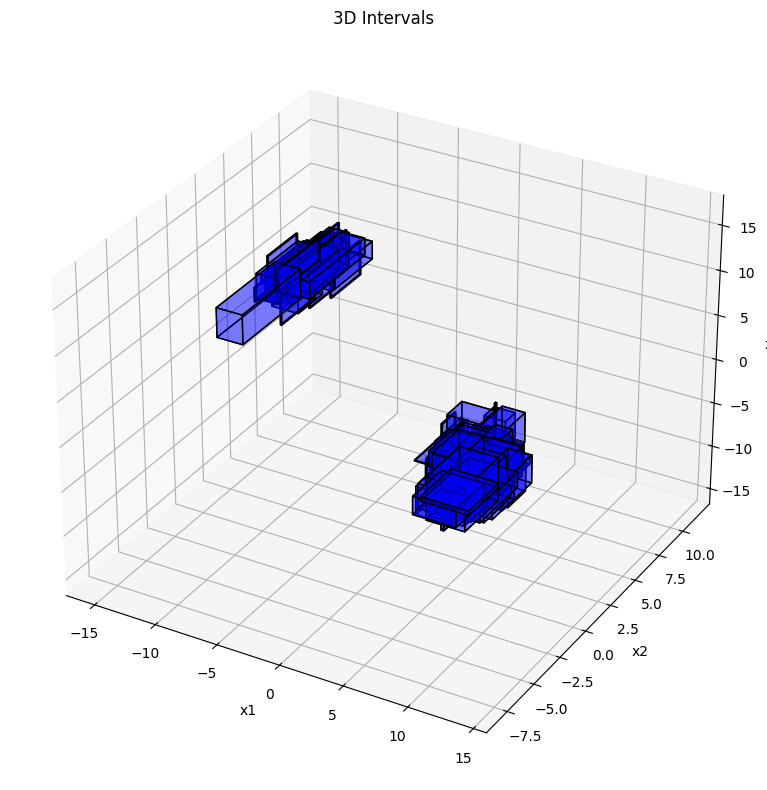

In [11]:
fig, ax = Interval3d.visualize(intervals = random_data.get_intervals(), centroids= None, labels = None)

L Method optimal k: 3
Elbow Method optimal k: 4


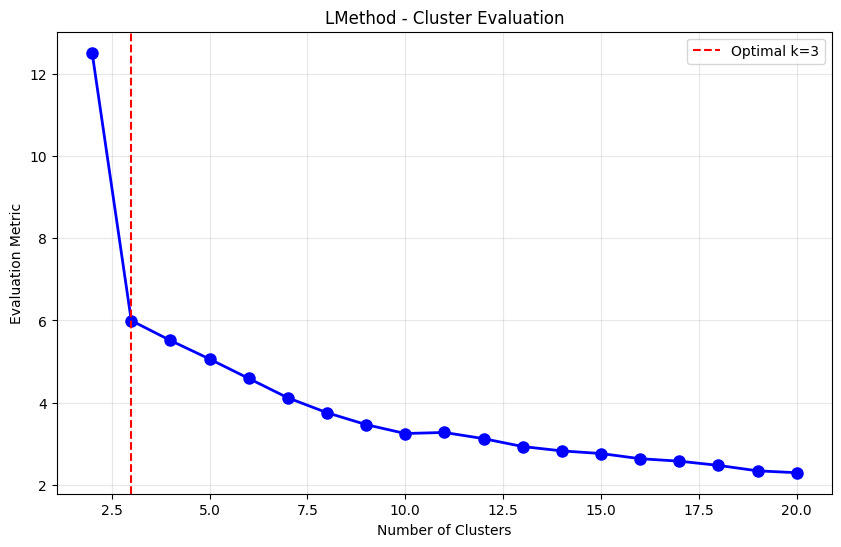

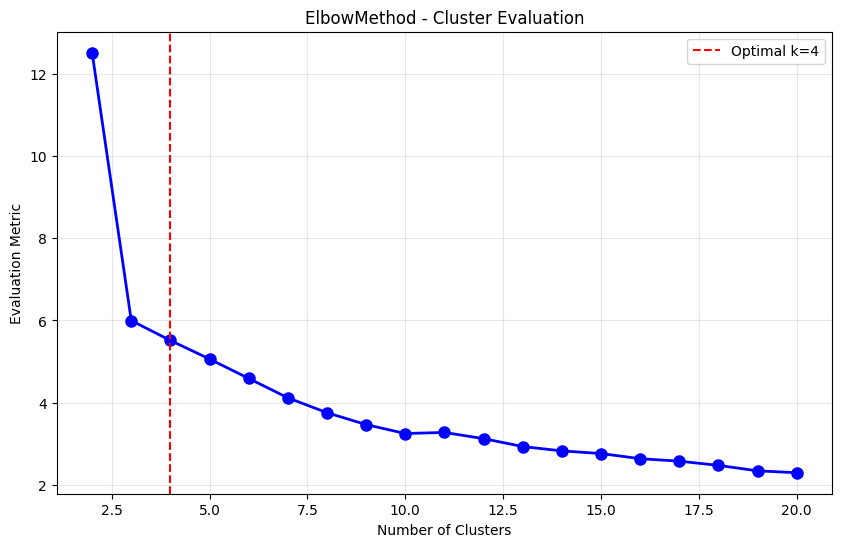

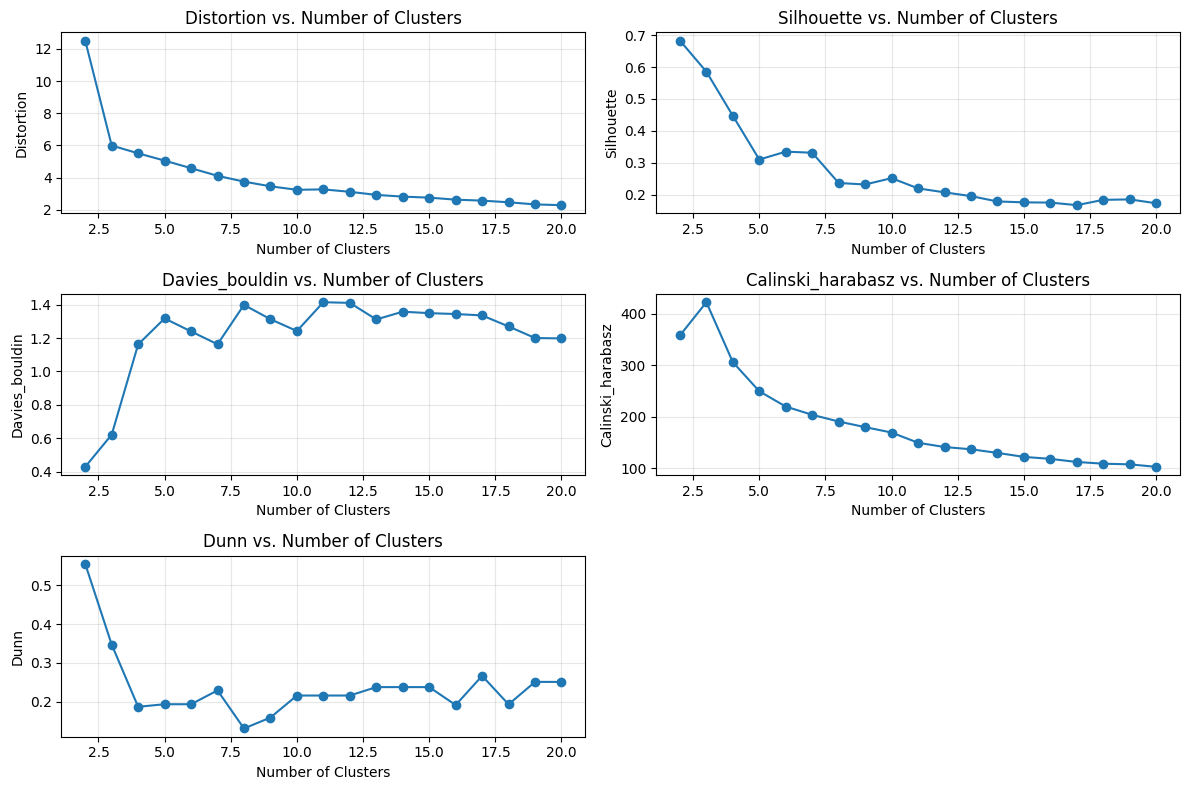

In [ ]:
# 用户代码示例
from interClusLib.cluster_number_analysis import LMethod, ElbowMethod

# 创建IntervalKMeans实例
kmeans = IntervalKMeans(distance_func='euclidean')

hc = IntervalAgglomerativeClustering(distance_func='euclidean')

# 计算不同k值下的评估指标
metric_results = kmeans.compute_metrics_for_k_range(
    interval_data,
    min_clusters=2,
    max_clusters=20,
    metrics=['distortion', 'silhouette', 'davies_bouldin','calinski_harabasz','dunn'],
    n_init=5
)

# 使用L方法确定最佳聚类数
l_method = LMethod(min_clusters=2, max_clusters=20)
optimal_k_l = l_method.evaluate(metric_results['distortion'])
plt = l_method.plot()
print(f"L Method optimal k: {optimal_k_l}")

# 使用肘部法则确定最佳聚类数
elbow = ElbowMethod(min_clusters=2, max_clusters=20, second_derivative= True, smooth= True)
optimal_k_elbow = elbow.evaluate(metric_results['distortion'])
print(f"Elbow Method optimal k: {optimal_k_elbow}")
plt = elbow.plot()

# 可视化结果
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for i, (metric_name, values) in enumerate(metric_results.items(), 1):
    plt.subplot(3, 2, i)
    x = list(values.keys())
    y = list(values.values())
    plt.plot(x, y, 'o-')
    plt.title(f"{metric_name.capitalize()} vs. Number of Clusters")
    plt.xlabel("Number of Clusters")
    plt.ylabel(metric_name.capitalize())
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

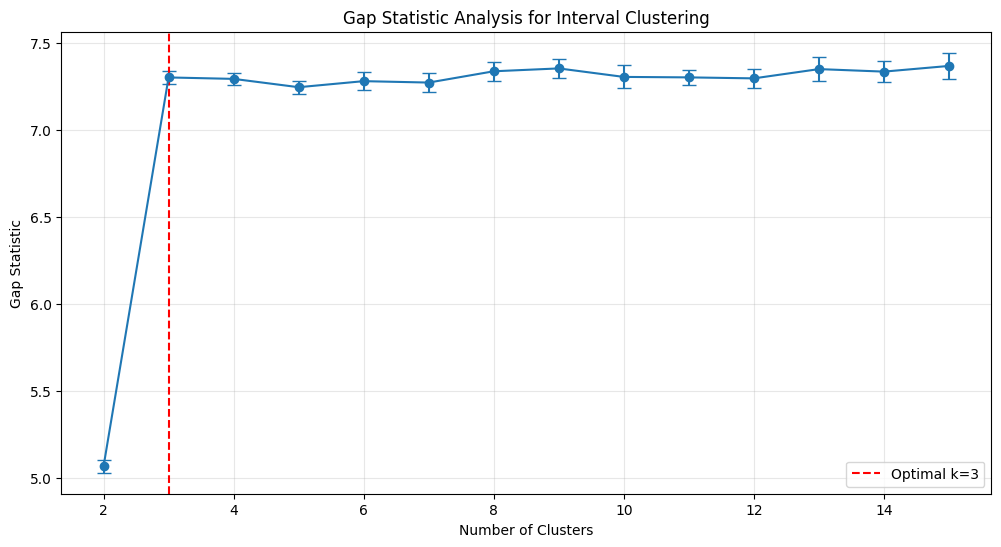

Optimal number of clusters according to Gap Statistic: 3


In [ ]:
# 使用已有的 Gap Statistic 实现进行聚类分析
from interClusLib.cluster_number_analysis import GapStatistic
import matplotlib.pyplot as plt

# 收集区间聚类的评估指标
kmeans = IntervalKMeans(distance_func='euclidean')
metrics = kmeans.compute_metrics_for_k_range(
    interval_data, 
    min_clusters=2, 
    max_clusters=15,
    metrics=['distortion'],
    n_init=5
)

# 定义一个包装函数，用于运行聚类
def run_clustering(data, k):
    """对数据运行区间聚类并返回标签和中心点"""
    model = IntervalKMeans(n_clusters=k, distance_func='euclidean')
    model.fit(data)
    return model.labels_, model.centroids_

# 初始化 GapStatistic
gap_evaluator = GapStatistic(min_clusters=2, max_clusters=15, n_refs=10)

# 使用 GapStatistic 确定最佳聚类数
optimal_k = gap_evaluator.evaluate(
    eval_data=metrics['distortion'],
    raw_data=interval_data,
    cluster_func=run_clustering
)

# 可视化结果
gap_evaluator.plot_gap()
plt.title("Gap Statistic Analysis for Interval Clustering")
plt.show()

print(f"Optimal number of clusters according to Gap Statistic: {optimal_k}")

# 使用最佳聚类数训练最终模型
final_model = IntervalKMeans(n_clusters=optimal_k, distance_func='euclidean')
final_model.fit(interval_data)

optimal_k:
- silhouette: best k = 3


/var/folders/xw/3jk8jclj72zgxr733zl929m80000gn/T/ipykernel_51898/2796284204.py:39: UserWarning: Glyph 25351 (\N{CJK UNIFIED IDEOGRAPH-6307}) missing from current font.
  plt.tight_layout()
/var/folders/xw/3jk8jclj72zgxr733zl929m80000gn/T/ipykernel_51898/2796284204.py:39: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from current font.
  plt.tight_layout()
/var/folders/xw/3jk8jclj72zgxr733zl929m80000gn/T/ipykernel_51898/2796284204.py:39: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  plt.tight_layout()


<Figure size 800x500 with 0 Axes>

/Users/jiashuchen/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25351 (\N{CJK UNIFIED IDEOGRAPH-6307}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jiashuchen/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jiashuchen/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


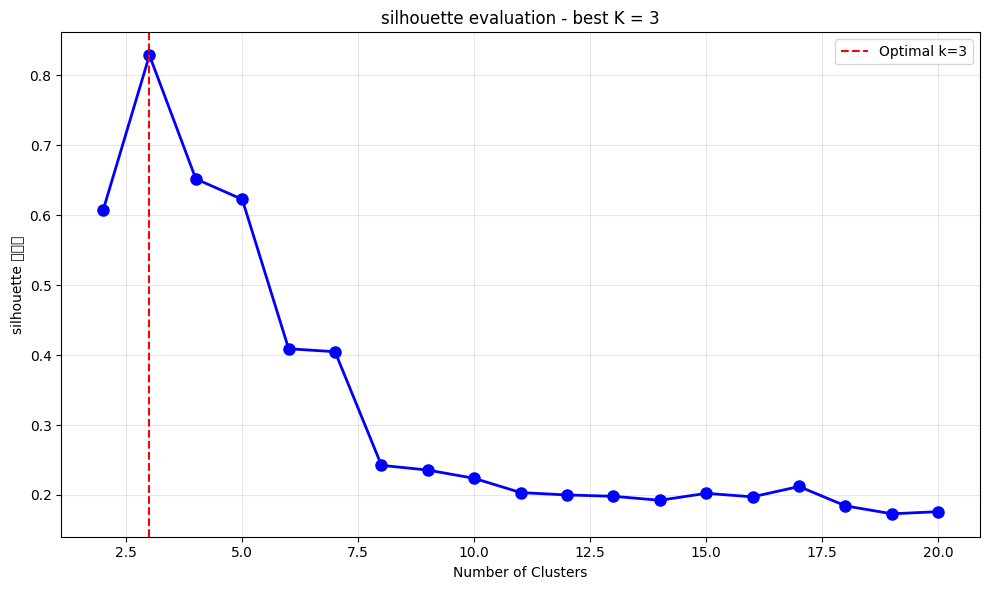

- davies_bouldin: best k = 3


<Figure size 800x500 with 0 Axes>

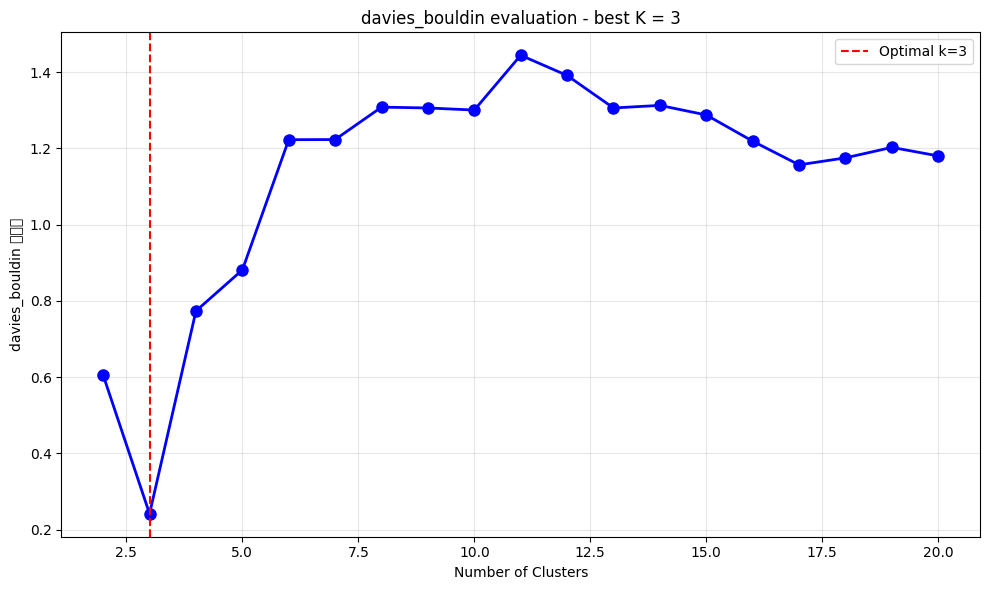

- calinski_harabasz: best k = 3


<Figure size 800x500 with 0 Axes>

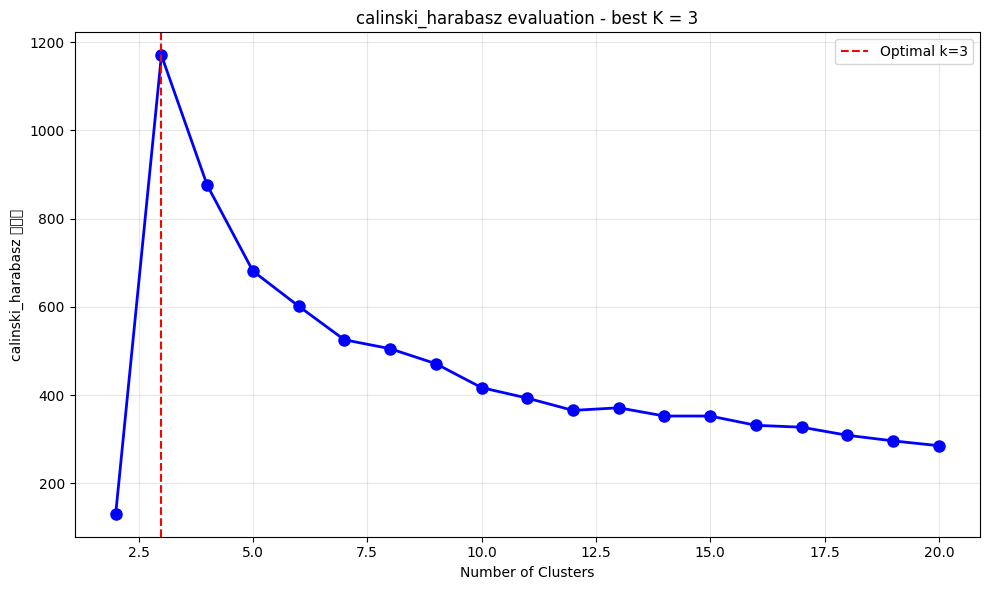

- dunn: best k = 3


<Figure size 800x500 with 0 Axes>

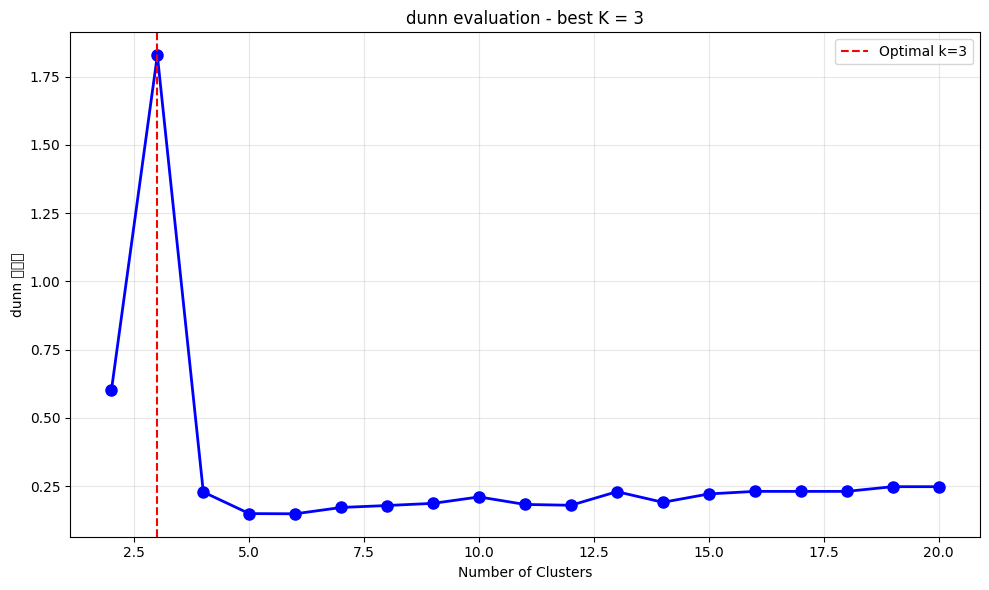

In [ ]:
from interClusLib.cluster_number_analysis import MaxMinClusterEvaluator

kmeans = IntervalKMeans(n_clusters=3, distance_func='euclidean', random_state=42)

# 计算多个评估指标
min_clusters = 2
max_clusters = 20
metrics = ['silhouette', 'davies_bouldin', 'calinski_harabasz', 'dunn']
metric_results = kmeans.compute_metrics_for_k_range(
    interval_data, 
    min_clusters=min_clusters,
    max_clusters=max_clusters,
    metrics=metrics,
    n_init=5  # 每个k值运行3次，选择最佳结果
)

# 使用MaxMinClusterEvaluator找到最佳聚类数量
print("optimal_k:")
for metric_name in metrics:
    # 为每个评估指标创建评估器实例
    evaluator = MaxMinClusterEvaluator(
        min_clusters=min_clusters,
        max_clusters=max_clusters,
        metric=metric_name  # 自动设置find_max参数
    )
    
    # 评估最佳聚类数量
    best_k = evaluator.evaluate(metric_results[metric_name])
    
    # 显示结果
    print(f"- {metric_name}: best k = {best_k}")
    
    # 可视化结果
    plt.figure(figsize=(8, 5))
    evaluator.plot(
        title=f"{metric_name} evaluation - best K = {best_k}",
        ylabel=f"{metric_name}"
    )
    plt.tight_layout()
    plt.show()

# 使用确定的最佳k值训练最终模型
# 假设我们选择基于silhouette分数的最佳k值
silhouette_evaluator = MaxMinClusterEvaluator(metric='silhouette')
best_k_silhouette = silhouette_evaluator.evaluate(metric_results['silhouette'])

final_model = IntervalKMeans(n_clusters=best_k_silhouette, 
                            distance_func='euclidean',
                            random_state=42)
final_model.fit(interval_data)
